<a href="https://colab.research.google.com/github/Raychanan/ray_content_final_project/blob/main/content_final_week5_network_SUBMIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Raychanan/ray_content_final_project

!pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

Cloning into 'ray_content_final_project'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 9), reused 20 (delta 3), pack-reused 0
Unpacking objects: 100% (29/29), done.
  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-iyqoc3n5
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-iyqoc3n5
     |████████████████████████████████| 5.5MB 12.1MB/s 
     |████████████████████████████████| 122kB 57.4MB/s 
     |████████████████████████████████| 163kB 61.3MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 133kB 67.1MB/s 
     |████████████████████████████████| 32.8MB 164kB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 5.1MB 66.7MB/s 
     |██████████████████████

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import pandas as pd
import seaborn as sns
#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# An Introduction to networks in *networkx*

In [ ]:
covid_df = pd.read_csv("/content/ray_content_final_project/Corona_NLP_train_utf8.csv", header=0)

covid_df.dropna(inplace=True) # dropna
# now_df.drop("Unnamed: 0", axis=1, inplace=True) # drop column
covid_df.rename(columns={'OriginalTweet':'text', "Sentiment":'sentiment'}, inplace=True) #renmae column

covid_df
covid_df = covid_df.sample(n=5000, random_state=123)

In [ ]:
covid_df.reset_index(drop=True, inplace=True)
covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative
1,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive
2,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive
3,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative
4,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral
...,...,...,...,...,...,...
4995,34189,79141,"Nottingham, England",06-04-2020,Ready to do work - PC issues.\r\r\nEventually ...,Extremely Positive
4996,17897,62849,Earth,21-03-2020,#RealNews trustworthy #worldnews. \r\r\nEmpty ...,Extremely Negative
4997,21510,66462,"Flagstaff, AZ",23-03-2020,Reminder Lumberjacks Scammers are taking advan...,Extremely Positive
4998,7565,52517,"Brooklyn, New York",18-03-2020,To all of those people who are making it a hab...,Positive


In [ ]:
covid_df['tokenized_sents'] = covid_df['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
covid_df['normalized_sents'] = covid_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

Let's begin by looking at words that co-occur in the sentences:

In [ ]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [ ]:
covid_df['normalized_sents']

0       [[gas, price, drop, record, low, place], [covi...
1       [[sale, face, mask, 3ply, n95, rapid, covid-19...
2       [[impact, covid-19, reach, way, gas, tank, pri...
3       [[3x, consumer, worry, dye, covid-19, lose, jo...
4       [[toiletpaper], [coronavirus, https://t.co/lqs...
                              ...                        
4995    [[ready, work, pc, issue], [eventually, manage...
4996    [[realnews, trustworthy, worldnews], [counter,...
4997    [[reminder, lumberjack, scammer, take, advanta...
4998    [[people, make, habit, selfish, hoard, supply,...
4999    [[covid], [19-], [panic, buy, supermarket, htt...
Name: normalized_sents, Length: 5000, dtype: object

In [ ]:
covid_df['normalized_sents'][0] #each array is a list of sentences

[['gas', 'price', 'drop', 'record', 'low', 'place'],
 ['covid19', 'coronavirus', 'oilprices', 'gasprices', 'fuelprices']]

In [ ]:
covid_df['normalized_sents'][0][1] #each sentence is a list of words

['covid19', 'coronavirus', 'oilprices', 'gasprices', 'fuelprices']

First, we want a list of words that occurred at least once in this corpus. Then, second, we want a word-word co-occurrence matrix. This is a square matrix (i.e. matrix with the name number of rows and columns), the rows and columns of which are words, and the entries of which refer to how many times these two words appeared together in sentences.

Let's start with the first task: getting a complete list of words in the corpus. 

In [ ]:
g = wordCooccurrence(covid_df['normalized_sents'][:100].sum())

Total number of vertices:

In [ ]:
len(g.nodes)

1004

Total number of edges:

In [ ]:
len(g.edges)

6449

A part of the adjacency matrix of cleaned word by press releases:

In [ ]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [ ]:
#nx.write_graphml(g, '/content/Homework-Notebooks/data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's use the document-word frequency matrix.

In [ ]:
def tokenize(text):
    tokenlist = lucem_illud.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist)
    return normalized

In [ ]:
import sklearn.feature_extraction
# in case we get a module not found error

In [ ]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(covid_df['text'][:100])

In [ ]:
senVects_incidence.shape

(100, 1004)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [ ]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [ ]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 1104
Number of edges: 1616
Average degree:   2.9275


Let's plot the bipartite network with a quick spring layout

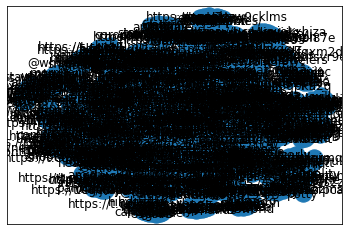

In [ ]:
nx.draw_networkx(g_2mode)

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share

In [ ]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [ ]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:
让我们首先来看一下文档到文档网络：

In [ ]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2477
Average degree:  49.5400


almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

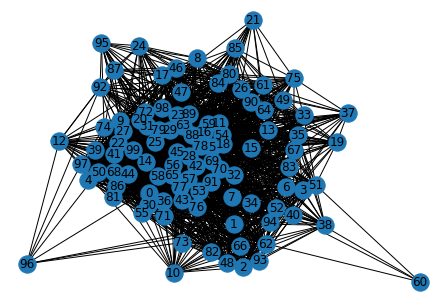

In [ ]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished

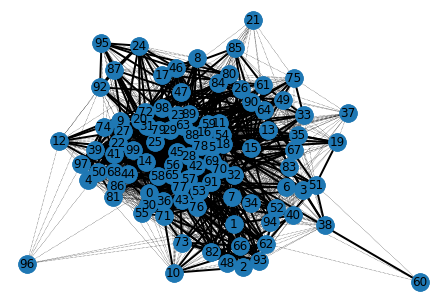

In [ ]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [ ]:
print(len(covid_df.iloc[60]['text']),"words:","\n",covid_df.iloc[60]['text'].strip().replace('  ', '\n'))

30 words: 
 It starts the potty training


In [ ]:
print(len(covid_df.iloc[28]['text']),"words:","\n",covid_df.iloc[28]['text'].strip().replace('  ', '\n'))

270 words: 
 By enforcing social distancing while moving through an aisle in a supermarket is actually going to cause more effective virus transmission as people waiting causes a higher chance of person coughing or sneezing into a crowd #coronavirus #covid19uk #covid19 #supermarkets


those documents with the **most** words are unsprisingly the most central in this simple document network.

look at the word-to-word network by documents. 

In [ ]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 1004
Number of edges: 13370
Average degree:  26.6335


First, let's reduce the number of words to a manageable size.

In [ ]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.0489154824233358

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. 

In [ ]:
g = wordCooccurrence(covid_df['normalized_sents'][:5000].sum())

In [ ]:
len(g)

16578

In [ ]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [ ]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [ ]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [ ]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 135
Number of edges: 418
Average degree:   6.1926


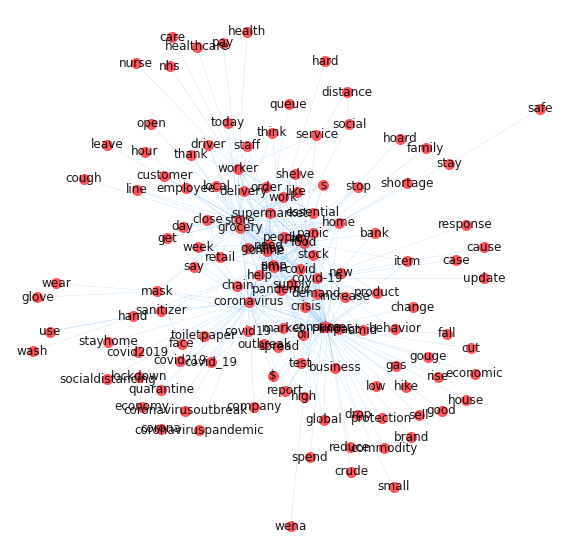

In [ ]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Very intuitive results, a few key points: Coronavirus, Store, Food

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

We can also remove those words that show up in many documents

In [ ]:
giant = nx.Graph(giant)

In [ ]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 135
Number of edges: 418
Average degree:   6.1926


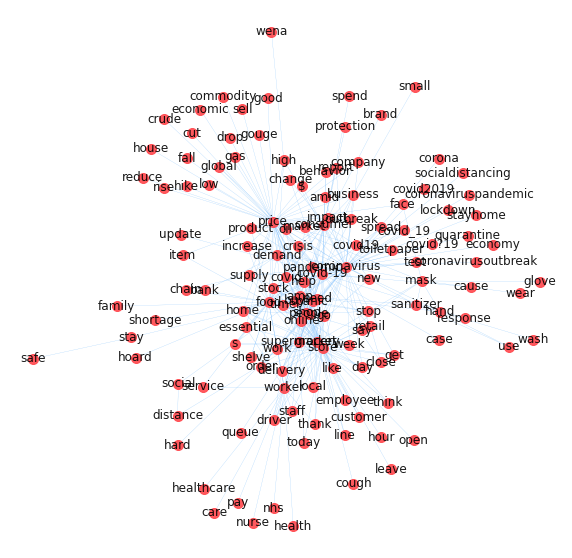

In [ ]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Moreover, we can find cliques, or completely connected sets of nodes. 

In [ ]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

coronavirus, price, covid-19, amp, food, people, store, shop, pandemic


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps

In [ ]:
americanNeighbors = giant.neighbors('covid')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: Graph
Number of nodes: 9
Number of edges: 34
Average degree:   7.5556


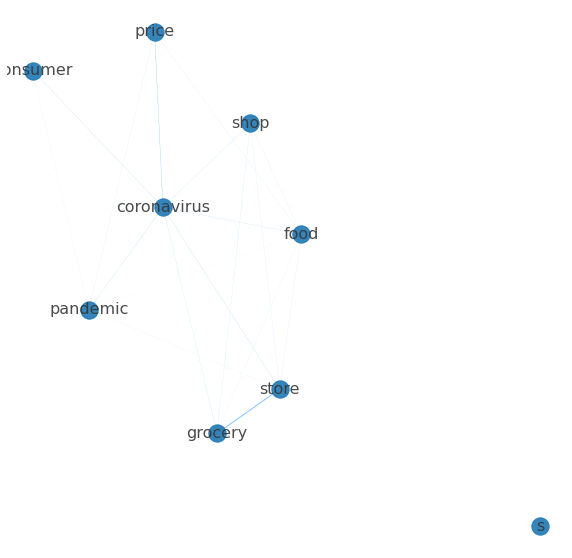

In [ ]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Name: 
Type: Graph
Number of nodes: 62
Number of edges: 288
Average degree:   9.2903


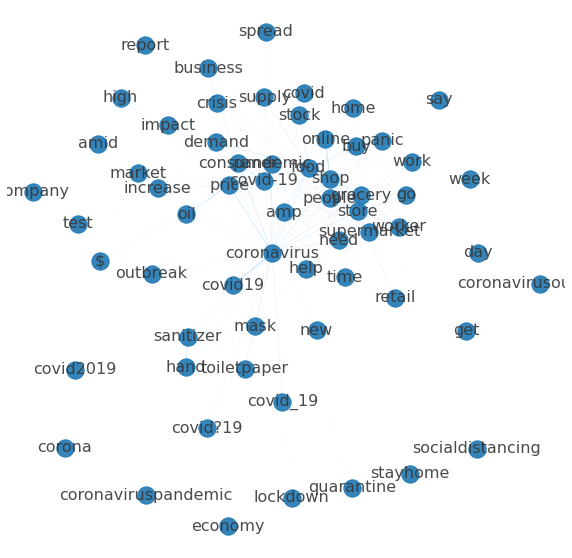

In [ ]:
americanNeighbors = giant.neighbors('coronavirus')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [ ]:
americanNeighbors = gWord.neighbors('covid')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [ ]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 114
Average degree:   7.8621


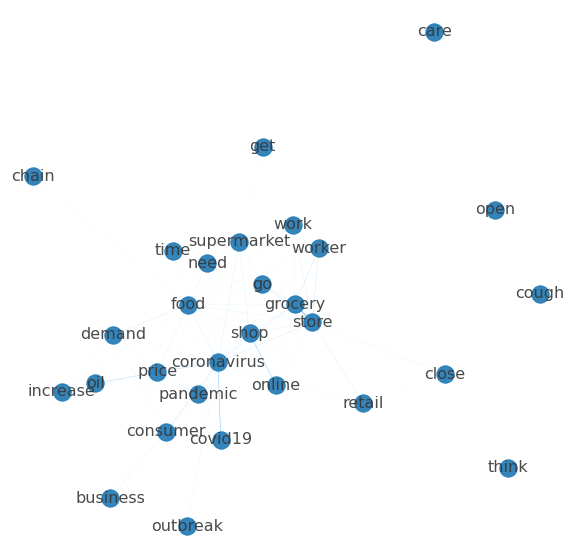

In [ ]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Network Statistics


In [ ]:
dcentralities = nx.degree_centrality(giant)

In [ ]:
dcentralities['coronavirus']

0.47014925373134325

In [ ]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])

[('coronavirus', 0.47014925373134325),
 ('price', 0.41044776119402987),
 ('store', 0.35074626865671643),
 ('food', 0.3283582089552239),
 ('covid-19', 0.291044776119403),
 ('grocery', 0.23880597014925373),
 ('amp', 0.20149253731343283),
 ('people', 0.19402985074626866),
 ('supermarket', 0.18656716417910446),
 ('shop', 0.1791044776119403),
 ('consumer', 0.1791044776119403),
 ('worker', 0.17164179104477612),
 ('pandemic', 0.11194029850746269),
 ('need', 0.1044776119402985),
 ('buy', 0.09701492537313433),
 ('demand', 0.08955223880597014),
 ('work', 0.08955223880597014),
 ('mask', 0.08208955223880597),
 ('online', 0.08208955223880597),
 ('home', 0.07462686567164178),
 ('go', 0.07462686567164178),
 ('oil', 0.06716417910447761),
 ('time', 0.06716417910447761),
 ('panic', 0.06716417910447761),
 ('covid', 0.06716417910447761),
 ('stock', 0.06716417910447761),
 ('help', 0.06716417910447761),
 ('delivery', 0.05970149253731343),
 ('supply', 0.05970149253731343),
 ('hand', 0.05970149253731343),
 ('

In [ ]:
max(dcentralities.items(), key = lambda x : x[1])

('coronavirus', 0.47014925373134325)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout

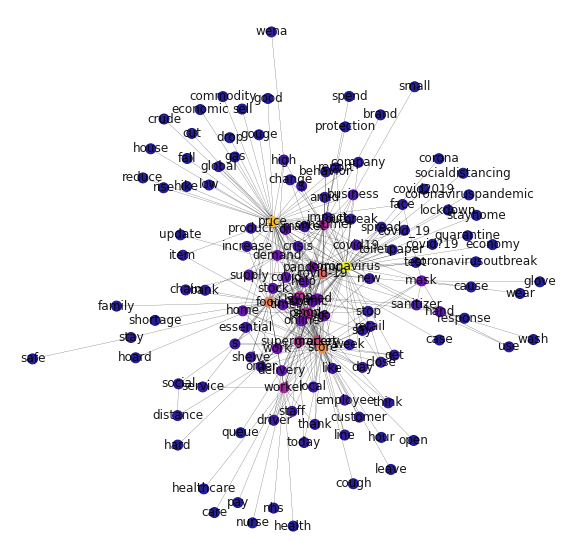

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight

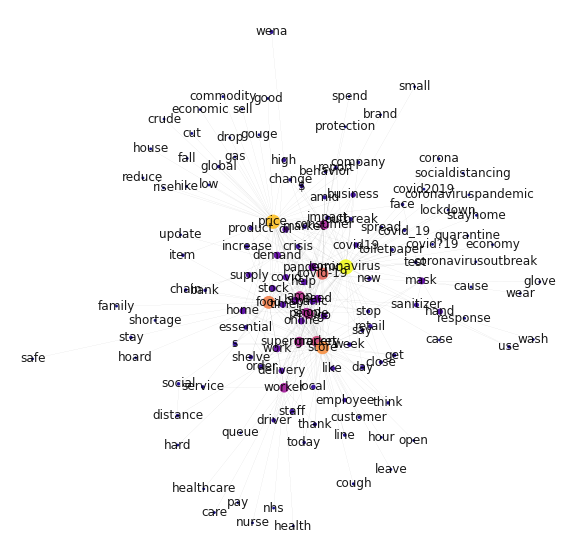

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is

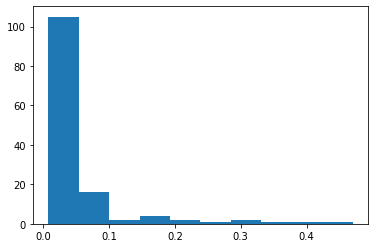

In [ ]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('coronavirus', 0.47014925373134325),
 ('price', 0.41044776119402987),
 ('store', 0.35074626865671643),
 ('food', 0.3283582089552239),
 ('covid-19', 0.291044776119403),
 ('grocery', 0.23880597014925373),
 ('amp', 0.20149253731343283),
 ('people', 0.19402985074626866),
 ('supermarket', 0.18656716417910446),
 ('shop', 0.1791044776119403)]

people care price, store, food, grocery, supermarket, shop

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('good', 0.007462686567164179),
 ('covid2019', 0.007462686567164179),
 ('healthcare', 0.007462686567164179),
 ('protection', 0.007462686567164179),
 ('economy', 0.007462686567164179),
 ('low', 0.007462686567164179),
 ('brand', 0.007462686567164179),
 ('house', 0.007462686567164179),
 ('pay', 0.007462686567164179),
 ('family', 0.007462686567164179)]

Consider another very different measure, which is betweenness centrality.

In [ ]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [ ]:
centralities['coronavirus']

0.3197248487912228

In [ ]:
max(centralities.items(), key = lambda x : x[1])

('coronavirus', 0.3197248487912228)

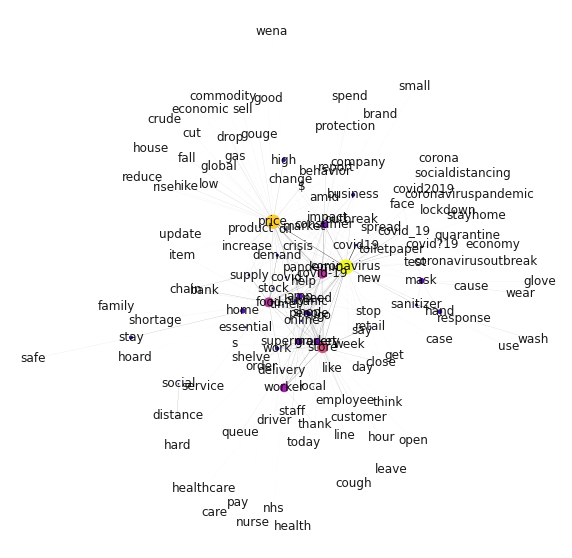

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

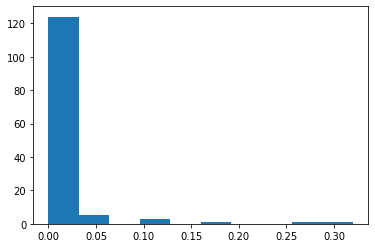

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('coronavirus', 0.47014925373134325),
 ('price', 0.41044776119402987),
 ('store', 0.35074626865671643),
 ('food', 0.3283582089552239),
 ('covid-19', 0.291044776119403),
 ('grocery', 0.23880597014925373),
 ('amp', 0.20149253731343283),
 ('people', 0.19402985074626866),
 ('supermarket', 0.18656716417910446),
 ('shop', 0.1791044776119403)]

What are words lower down? 

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('good', 0.007462686567164179),
 ('covid2019', 0.007462686567164179),
 ('healthcare', 0.007462686567164179),
 ('protection', 0.007462686567164179),
 ('economy', 0.007462686567164179),
 ('low', 0.007462686567164179),
 ('brand', 0.007462686567164179),
 ('house', 0.007462686567164179),
 ('pay', 0.007462686567164179),
 ('family', 0.007462686567164179)]

We can also look at closeness centrality

In [ ]:
centralities = nx.closeness_centrality(giant)

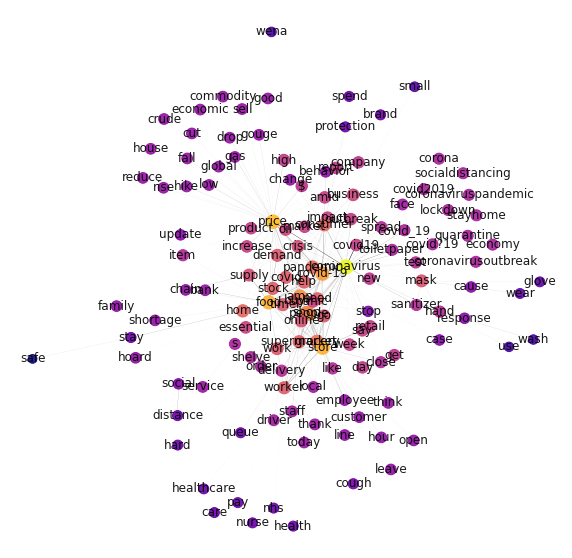

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('coronavirus', 0.6442307692307693),
 ('price', 0.5877192982456141),
 ('food', 0.575107296137339),
 ('store', 0.575107296137339),
 ('covid-19', 0.5560165975103735),
 ('amp', 0.5381526104417671),
 ('people', 0.5275590551181102),
 ('shop', 0.5234375),
 ('grocery', 0.5075757575757576),
 ('pandemic', 0.4962962962962963)]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('healthcare', 0.3228915662650602),
 ('pay', 0.3228915662650602),
 ('hard', 0.3198090692124105),
 ('glove', 0.31678486997635935),
 ('wear', 0.31678486997635935),
 ('small', 0.30663615560640733),
 ('wena', 0.2984409799554566),
 ('use', 0.29004329004329005),
 ('wash', 0.2894168466522678),
 ('safe', 0.24860853432282004)]

Or eignvector centrality

In [ ]:
centralities = nx.eigenvector_centrality(giant)

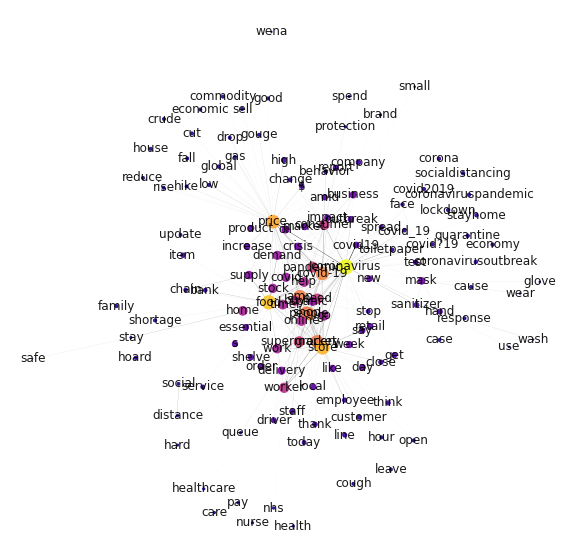

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

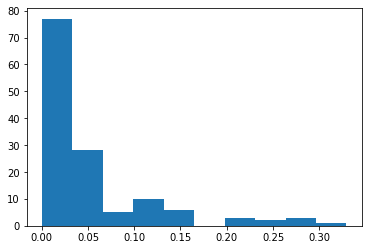

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('coronavirus', 0.32927731742600735),
 ('food', 0.2899392797065206),
 ('store', 0.2741101891947503),
 ('price', 0.26453129947937615),
 ('covid-19', 0.23869936542545295),
 ('people', 0.2307215429362828),
 ('amp', 0.22987400825227997),
 ('grocery', 0.22553703440503106),
 ('shop', 0.22200094134539886),
 ('supermarket', 0.16470370057575515)]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('pay', 0.007929924155006447),
 ('stay', 0.006898831491204854),
 ('hard', 0.006676386421388995),
 ('use', 0.004320760498856123),
 ('glove', 0.003948102221186297),
 ('wear', 0.003948102221186297),
 ('small', 0.0035677931543536),
 ('wena', 0.0023241072079857785),
 ('wash', 0.002222379203101143),
 ('safe', 0.0003849080511699743)]

We can now filter our network by a centrality measure：

In [ ]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [ ]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 141
Average degree:  11.2800


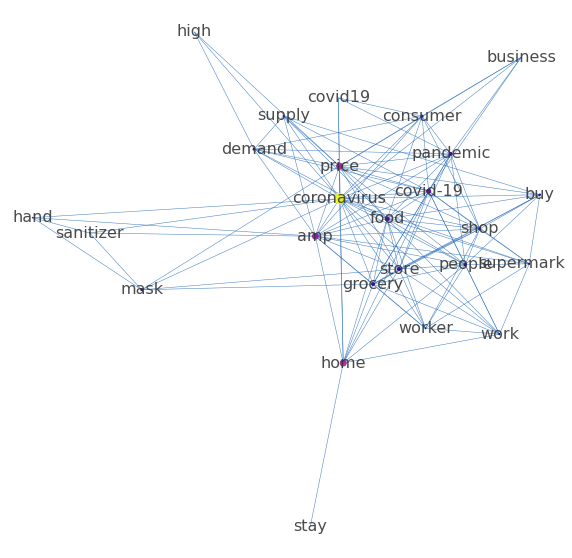

In [ ]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges

In [ ]:
nx.density(giant)

0.04621337755666114

We can also calculate the average degree per node

In [ ]:
np.mean([v for w,v in nx.degree(giant)])

6.192592592592592

The diameter calculates the average distance between any two nodes in the network: Diameter

In [ ]:
nx.diameter(giant)

5